In [1]:
import pandas_datareader as wb, pandas as pd, datetime, matplotlib.pyplot as plt, numpy as np
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 5, 17)
df_null = wb.DataReader("KOSPI", "naver", start, end)
df = df_null['Close'].dropna().astype('float')

### Conditional Heteroscedastic Models

The univariate volatility models discussed in this chapter include the autoregres- sive conditional heteroscedastic (ARCH) model of Engle (1982), the generalized ARCH (GARCH) model of Bollerslev (1986), the exponential GARCH (EGARCH) model of Nelson (1991), the threshold GARCH (TGARCH) model of Glosten, Jagannathan, and Runkle (1993) and Zakoian (1994), the conditional heteroscedas- tic autoregressive moving-average (CHARMA) model of Tsay (1987), the random coefficient autoregressive (RCA) model of Nicholls and Quinn (1982), and the stochastic volatility (SV) models of Melino and Turnbull (1990), Taylor (1994), Harvey, Ruiz, and Shephard (1994), and Jacquier, Polson, and Rossi (1994). We also discuss advantages and weaknesses of each volatility model and show some applications of the models. Multivariate volatility models, including those with time-varying correlations, are discussed in Chapter 10.

#### 1. Characteristics of Vaolatility

The resulting value of σt is called the implied volatility of the underlying stock. However, this implied volatility is derived under the assumption that the price of the underlying asset follows a geometric Brownian motion. It might be different from the actual volatility. Experience shows that implied volatility of an asset return tends to be larger than that obtained by using a GARCH type of volatility model. This might be due to the risk premium for volatility or to the way daily returns are calculated. The VIX of CBOE is an implied volatility.

**Some characteristics of volatilities**
- there exist volatility clusters
- volatility evolves over time in a continuous manner
- volatility does not diverge to infinity
- volatility seems to react differently to a big price increase or a big price drop, referred to as the leverage effect

#### 2. Structure of a Model

To put the volatility models in proper perspective, it is informative to consider the conditional mean and variance of $r_t$ given $F_{t−1}$

$$\mu_t = E(r_t|F_{t-1}), ~~~~~ \sigma_t^2 = \mathrm{Var}(r_t|F_{t-1}) = E[(r_t - \mu_t)^2|F_{t-1}]$$

where $F_{t−1}$ denotes the information set available at time $t − 1$. we assume that rt follows a simple time series model such as a stationary $\mathrm{ARMA}(p, q)$ model with some explanatory variables. In other words, we entertain the model

$$r_t = \mu_t + a_t, ~~~ \mu_t = \sum_{i=1}^p \phi _i y_{t-i} - \sum_{i=1}^q \theta_i a_{t-i}, ~~~~ y_t = r_t - \phi_0 - \sum_{i=1}^k \beta_i x_{it}$$

In [3]:
ret = np.log(df) - np.log(df.shift())
ret = ret.dropna()
ret

Date
2010-01-05   -0.003260
2010-01-06    0.008657
2010-01-07   -0.012908
2010-01-08    0.006991
2010-01-11   -0.000673
                ...   
2023-05-11   -0.002210
2023-05-12   -0.006274
2023-05-15    0.001586
2023-05-16    0.000359
2023-05-17    0.005797
Name: Close, Length: 3300, dtype: float64

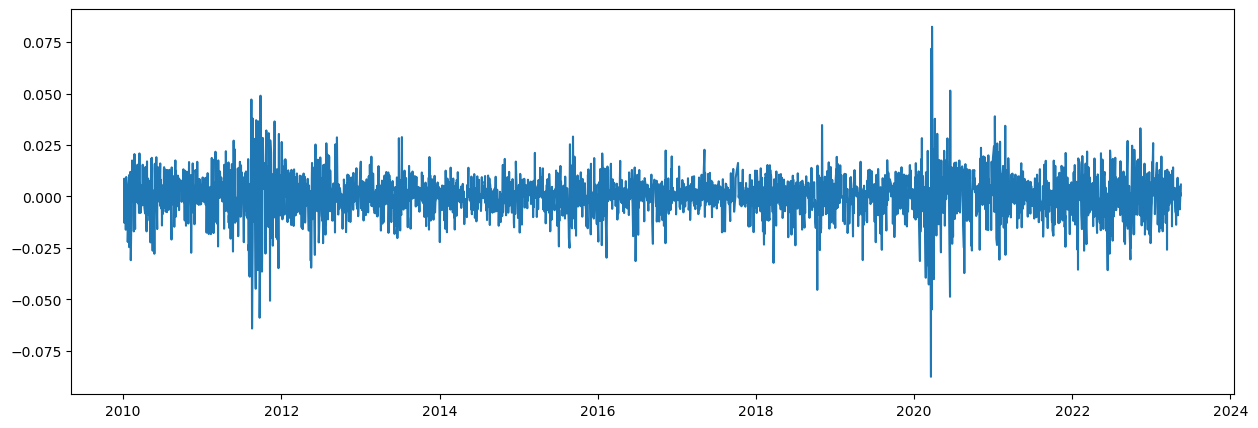

In [4]:
plt.style.use('default')
plt.figure(figsize = (15,5))
plt.plot(ret)

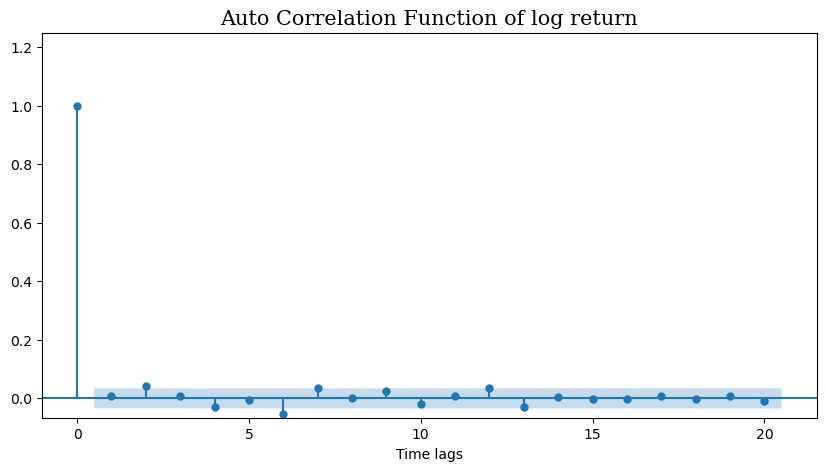

In [9]:
import statsmodels.tsa.stattools as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ret, auto_ylims = True, lags = 20, title = 'ACF of KOSPI return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function of log return', fontsize = 15, fontfamily = 'Serif')
plt.show()

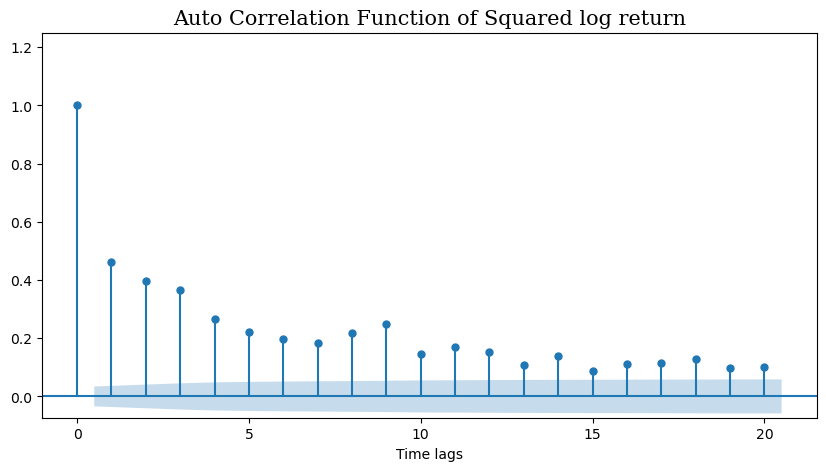

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(ret**2, auto_ylims = True, lags = 20, title = 'ACF of KOSPI return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function of Squared log return', fontsize = 15, fontfamily = 'Serif')
plt.show()

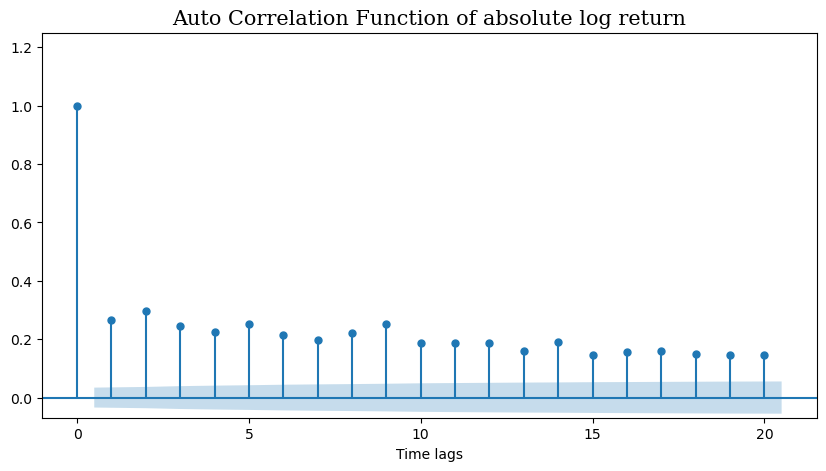

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(np.abs(ret), auto_ylims = True, lags = 20, title = 'ACF of KOSPI return' , ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Auto Correlation Function of absolute log return', fontsize = 15, fontfamily = 'Serif')
plt.show()

<Figure size 1000x800 with 0 Axes>

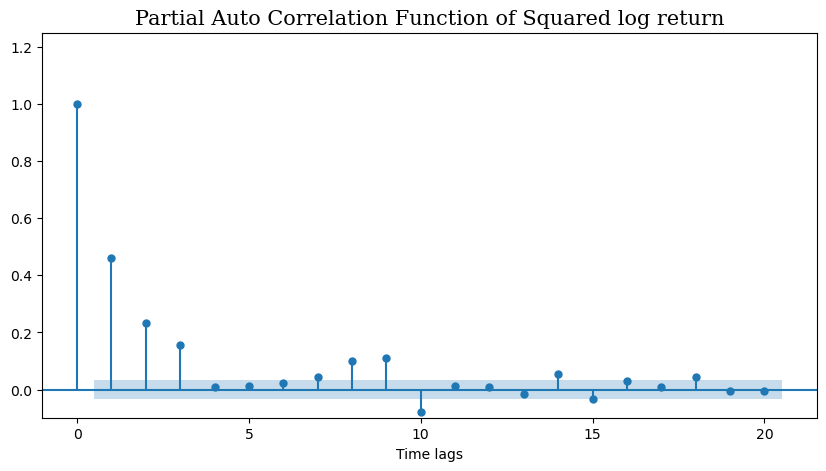

In [12]:
plt.figure(figsize = (10,8))
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(ret**2, auto_ylims = True, lags = 20, title = 'PACF of KOSPI log Index', ax = ax)
plt.xlabel('Time lags', fontsize = 10)
plt.title('Partial Auto Correlation Function of Squared log return', fontsize = 15, fontfamily = 'Serif')
plt.show()

return이 $\mathbf{IID}$가정을 따른다면 return을 제곱하거나 절댓값을 취해도 모두 stationary 해야 한다. 그러나, 실제로 데이터를 제곱하거나 절댓값을 취하여 ACF와 PACF를 확인하면 안정시계열이 되지 않는다

Therefore, modeling conditional heteroscedasticity amounts to augmenting a dynamic equation, which governs the time evolution of the conditional variance of the asset return, to a time series model.


#### 3. Model Building
Building a volatility model for an asset return series consists of four steps

1. Specify a mean equation by testing for serial dependence in the data and, if necessary, building an econometric model (e.g.,an ARMA model) for the return series to remove any linear dependence
2. Use the residuals of the mean equation to test for ARCH effects
3. Specify a volatility model if ARCH effects are statistically significant, and perform a joint estimation of the mean and volatility equations
4. Check the fitted model carefully and refine it if necessary

**Testing for ARCH effect**
For ease in notation, let $a_t = r_t − μ_t$ be the residuals of the mean equation. The squared series $a_t^2$ is then used to check for conditional heteroscedasticity, which is also known as the $\mathrm{ARCH}$ effects

$$a_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \cdots + \alpha_m a_{t-m}^2 + e_t, ~~~~~~ t = m+1, \cdots, T$$

 the null hypothesis is $H_0 : α_1 = \cdots = α_m = 0$. Let $\mathrm{SSR}_0$ Let $\mathrm{SSR}_0 = \sum^T_{t=m+1}(a_t^2 − \bar{ω})^2$, where $\bar{ω} = \frac{1}{T} \sum_{t=1}^T a_t^2$ is the sample mean of $a_t^2$, and $\mathrm{SSR}_1 = \sum^T_{t=m+1} \hat{e}_t^2$, where $\hat{e}_t$ is the least-squares residual of the prior linear regression. Then we have

$$F = \frac{(\mathrm{SSR}_0 - \mathrm{SSR}_1) / m}{\mathrm{SSR}_1 / (T - 2m - 1)}$$

which is asymptotically distributed as a chi-squared distribution with m degrees of freedom under the null hypothesis. The decision rule is to reject the null hypothesis if $F > χ_m^2(α)$, where $χ_m^2(α)$ is the upper $100(1 − α)$th percentile of $χ_m^2$ , or the $p$ value of $F$ is less than $α$, type-I error.

#### 4. The ARCH Model
The first model that provides a systematic framework for volatility modeling is the ARCH model of Engle (1982). The basic idea of ARCH models is that (a) the shock at of an asset return is serially uncorrelated, but dependent, and (b) the dependence of at can be described by a simple quadratic function of its lagged values. Specifically, an $\mathrm{ARCH}(m)$ model assumes that

$$a_t = σ_t\epsilon_t, ~~~~~~ σ_t^2 = α_0 +α_1a_{t−1}^2 +···+α_ma_{t−m}^2$$